In [3]:
# https://opencv.org/ -> tutorials
import cv2 

import numpy as np
import matplotlib.pyplot as plt

import tqdm

In [29]:
image = cv2.imread('./images/poodle.webp') # BGR
print(image.shape)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
print(image.shape)

(506, 900, 3)
(506, 900, 3)


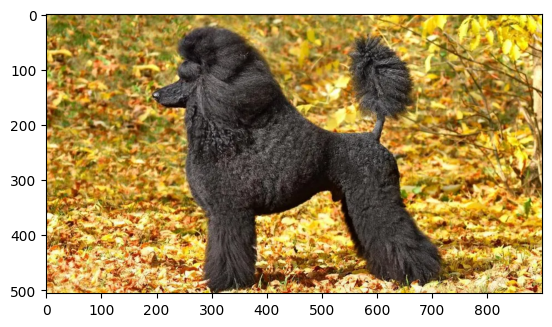

In [30]:
plt.imshow(image)
plt.show()


In [31]:
import torch

In [32]:
image = image.transpose(2, 0, 1)

In [33]:
# torch.nn.functional.conv2d
identity_filter = torch.tensor([
    [0, 0, 0],
    [0, 1, 0],
    [0, 0, 0]
]).unsqueeze(0).unsqueeze(0).float()  # [1, 1, 3, 3]

identity_filter = identity_filter.repeat(3, 3, 1, 1)

print(identity_filter.shape)

res = torch.nn.functional.conv2d(
    input=torch.from_numpy(image).float().unsqueeze(0),# .unsqueeze(0), # [B, C, H, W]
    weight=identity_filter,# [n_out_channels, n_in_channels / num_groups, F1, F2]
    stride=1, padding=1, dilation=1, groups=3
)

torch.Size([3, 3, 3, 3])


In [34]:
image.shape, res.shape

((3, 506, 900), torch.Size([1, 3, 506, 900]))

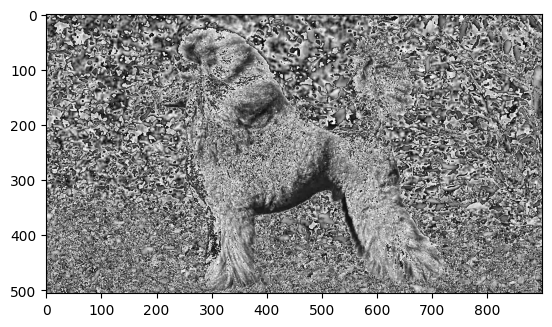

In [35]:
plt.imshow(res.detach().numpy()[0].transpose(1, 2, 0).astype(np.uint8))
plt.show()

In [24]:
torch.allclose(res.byte(), torch.from_numpy(image))

True

In [43]:
# torch.nn.functional.conv2d
identity_filter_rgb = torch.tensor([
    [0, 0, 0],
    [0, 1, 0],
    [0, 0, 0]
]).unsqueeze(0).unsqueeze(0).float()

In [44]:
image = cv2.imread('./images/poodle.webp')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = torch.from_numpy(image.transpose(2, 0, 1)).float().unsqueeze(0)

In [45]:
res = torch.nn.functional.conv2d(
    input=image,
    weight=identity_filter_rgb.repeat(3, 3, 1, 1),
    stride=1, padding=1, dilation=1, groups=1
)

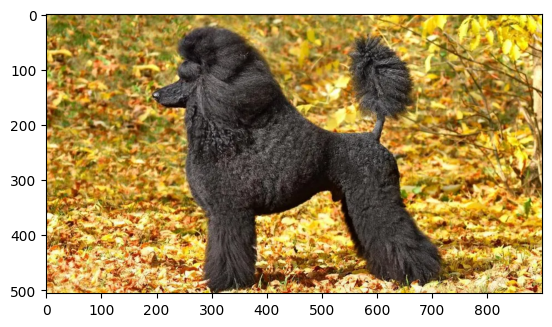

In [46]:
plt.imshow(res.detach().numpy()[0].transpose(1, 2, 0).astype(np.uint8))
plt.show()

In [47]:
torch.allclose(res, image)

True

In [ ]:
for s in (5,6):
    for p in (0,1):
        for d in (5,6):
            res = torch.nn.functional.conv2d(
                input=image,
                weight=identity_filter_rgb.repeat(3, 1, 1, 1),
                stride=s, padding=p, dilation=d, groups=3
            )
            plt.imshow(res.detach().numpy()[0].transpose(1, 2, 0).astype(np.uint8))
            plt.title(f"Stride={s}, padding={p}, dilation={d}, shape={res.shape}")
            plt.show()

In [52]:
# w = torch.zeros(1, 1, 3, 3)
# nn.init.dirac_(w)

w = torch.tensor(
    [
        [
            [1, 1, 1],
            [0, 0, 0],
            [-1, -1, -1]
        ]
    ]
).float()
w = w.repeat(3, 1, 1, 1)
conv_layer = torch.nn.Conv2d(3, 3, kernel_size=3, bias=False, padding=1, groups=3)
with torch.no_grad():
    conv_layer.weight.copy_(w)

In [53]:
res = conv_layer(image)

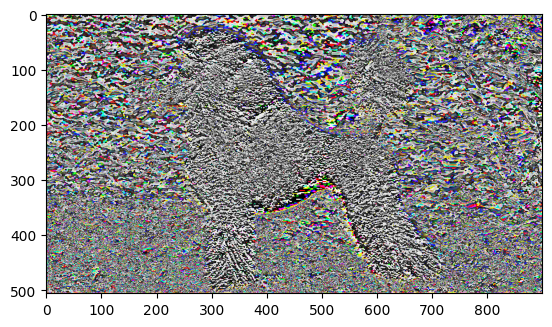

In [54]:
plt.imshow(res.detach().numpy()[0].transpose(1, 2, 0).astype(np.uint8))
plt.show()

In [ ]:
res

In [ ]:
image = cv2.imread('./images/poodle.webp')
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
image = torch.from_numpy(image).float().unsqueeze(0).unsqueeze(0)

In [ ]:
# w = torch.zeros(1, 1, 3, 3)
# nn.init.dirac_(w)

w = torch.tensor(
    [
        [
            [1, 1, 1],
            [1, 1, 1],
            [1, 1, 1]
        ]
    ]
).float() / 9.0
# w = w.repeat(1, 1, 1, 1)
# w = torch.tensor(
#     [
#         [
#             [1, 1, 1],
#             [0, 0, 0],
#             [-1, -1, -1]
#         ]
#     ]
# ).float()
conv_layer = nn.Conv2d(1, 1, kernel_size=3, bias=False, padding=1, groups=1, stride=1)
with torch.no_grad():
    conv_layer.weight.copy_(w)

In [ ]:
res = conv_layer(image)

In [ ]:
plt.imshow(res.detach().numpy()[0,0].astype(np.uint8), cmap='gray')
plt.show()

In [56]:
from torch import nn

In [57]:
class AlexNet(nn.Module):
    def __init__(self, num_classes=1000):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=96, kernel_size=11, stride=4),  # (b x 96 x 55 x 55)
            nn.ReLU(),
            nn.LocalResponseNorm(size=5, alpha=0.0001, beta=0.75, k=2),  # section 3.3
            nn.MaxPool2d(kernel_size=3, stride=2),  # (b x 96 x 27 x 27)
            nn.Conv2d(96, 256, 5, padding=2),  # (b x 256 x 27 x 27)
            nn.ReLU(),
            nn.LocalResponseNorm(size=5, alpha=0.0001, beta=0.75, k=2),
            nn.MaxPool2d(kernel_size=3, stride=2),  # (b x 256 x 13 x 13)
            nn.Conv2d(256, 384, 3, padding=1),  # (b x 384 x 13 x 13)
            nn.ReLU(),
            nn.Conv2d(384, 384, 3, padding=1),  # (b x 384 x 13 x 13)
            nn.ReLU(),
            nn.Conv2d(384, 256, 3, padding=1),  # (b x 256 x 13 x 13)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),  # (b x 256 x 6 x 6)
        )
        # classifier is just a name for linear layers
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(in_features=(256 * 6 * 6), out_features=4096),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(in_features=4096, out_features=4096),
            nn.ReLU(),
            nn.Linear(in_features=4096, out_features=num_classes),
        )
        self.init()  

    def init(self):
        for layer in self.net:
            if isinstance(layer, nn.Conv2d):
                nn.init.normal_(layer.weight, mean=0, std=0.01)
                nn.init.constant_(layer.bias, 0)
        # original paper = 1 for Conv2d layers 2nd, 4th, and 5th conv layers
        nn.init.constant_(self.net[4].bias, 1)
        nn.init.constant_(self.net[10].bias, 1)
        nn.init.constant_(self.net[12].bias, 1)

    def forward(self, x):
        """
        Pass the input through the net.

        Args:
            x (Tensor): input tensor

        Returns:
            output (Tensor): output tensor
        """
        x = self.net(x)
        # x = x.flatten()
        x = x.view(-1, 256 * 6 * 6)  # reduce the dimensions for linear layer input
        return self.classifier(x)

In [ ]:
image_resized = torch.nn.functional.interpolate(image, (227, 227))

In [ ]:
image_resized = image_resized.repeat(1, 3, 1, 1)

In [63]:
model = AlexNet(num_classes=10)

In [ ]:
model(image_resized)

In [58]:
import torch
import torchvision
import torchvision.transforms as transforms

In [66]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


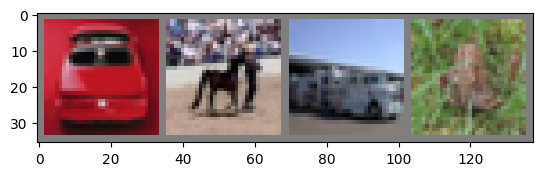

car   horse truck frog 


In [60]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [67]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [68]:
for epoch in tqdm.tqdm(range(2)):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in tqdm.tqdm(enumerate(trainloader)):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        inputs = torch.nn.functional.interpolate(inputs, (227, 227))
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

  0%|                                                     | 0/2 [00:00<?, ?it/s]
0it [00:00, ?it/s]
1it [00:00,  1.09it/s]
2it [00:01,  1.51it/s]
3it [00:01,  1.81it/s]
4it [00:02,  1.94it/s]
5it [00:02,  1.96it/s]
6it [00:03,  1.85it/s]
7it [00:03,  1.94it/s]
8it [00:04,  1.74it/s]
9it [00:05,  1.67it/s]
10it [00:05,  1.64it/s]
11it [00:06,  1.69it/s]
12it [00:06,  1.84it/s]
13it [00:07,  1.95it/s]
14it [00:07,  1.83it/s]
15it [00:09,  1.66it/s]
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x12129ad40>
Traceback (most recent call last):
  File "/Users/philmarchenko/.local/share/virtualenvs/Deep_learning_course_2024-1PtgDTri/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/Users/philmarchenko/.local/share/virtualenvs/Deep_learning_course_2024-1PtgDTri/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1443, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_

KeyboardInterrupt: 